In [1]:
import sqlite3
import csv
import pandas as pd
import traceback
import sys
from datetime import datetime
import matplotlib.pyplot as plt

# Challenge 2

In [2]:
db = "challenge.db"

### Conseguir la data de la base de datos y pasarla a DataFrames

In [3]:
depts = None
jobs = None
hired_employees = None

con = sqlite3.connect(db)

depts = pd.read_sql('SELECT * FROM DEPARTMENTS', con)
jobs = pd.read_sql('SELECT * FROM JOBS', con)
hired_employees = pd.read_sql('SELECT * FROM HIRED_EMPLOYEES', con)

con.close()

In [4]:
#Chequeo
hired_employees.head()

,id,name,datetime,department_id,job_id
0,1,Harold Vogt,2021-11-07T02:48:42Z,2.0,96.0
1,2,Ty Hofer,2021-05-30T05:43:46Z,8.0,NaN
2,3,Lyman Hadye,2021-09-01T23:27:38Z,5.0,52.0
3,4,Lotti Crowthe,2021-10-01T13:04:21Z,12.0,71.0
4,5,Gretna Lording,2021-10-10T22:22:17Z,6.0,80.0


In [5]:
# Convierto a Fecha
hired_employees['datetime'] = pd.to_datetime(hired_employees['datetime'])

In [6]:

# Armo un DF filtrado año 2021 y uniendo todas las tablas para obtener los nobmres de departament y job

start = '2021-01-01'
end = '2021-12-31'

df = hired_employees[(hired_employees['datetime'] >= start) & (hired_employees['datetime'] <= end)]

df = df.join(jobs.set_index('id'), on='job_id', how='left').join(depts.set_index('id'), on='department_id', how='left')


# chequeo
df[['department', 'job']].value_counts()

department                job                       
Support                   Recruiter                     8
                          Systems Administrator IV      8
Services                  Programmer IV                 8
Research and Development  Recruiter                     6
Support                   Programmer IV                 6
                                                       ..
Marketing                 Professor                     1
                          Programmer IV                 1
                          Quality Control Specialist    1
                          Quality Engineer              1
Training                  Web Developer III             1
Length: 937, dtype: int64

### Requerimiento 1 
Number of employees hired for each job and department in 2021 divided by quarter. The table mus be ordered by department and job

In [7]:
# Acá se arma el resumen pedido
resumen1 = pd.pivot_table(df, index=['department','job'], values='id' , aggfunc='count', columns=df['datetime'].dt.to_period('Q'), fill_value=0)
resumen1

D:\Users\juanp_schamun\AppData\Local\Temp\ipykernel_8792\609731053.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  resumen1 = pd.pivot_table(df, index=['department','job'], values='id' , aggfunc='count', columns=df['datetime'].dt.to_period('Q'), fill_value=0)


datetime                                  2021Q1  2021Q2  2021Q3  2021Q4
department job                                                          
Accounting Account Representative IV           1       0       0       0
           Actuary                             0       1       0       0
           Analyst Programmer                  0       0       1       0
           Budget/Accounting Analyst III       0       1       0       0
           Cost Accountant                     0       1       0       0
...                                          ...     ...     ...     ...
Training   Teacher                             0       2       0       0
           Technical Writer                    0       0       1       0
           VP Product Management               1       0       0       0
           VP Quality Control                  0       1       0       0
           Web Developer III                   0       1       0       0

[937 rows x 4 columns]

In [8]:
# Exportar a CSV
resumen1.to_csv(r'resumen1.csv', index=True)

### Requerimiento 2
List of ids, name and number of employees hired of each department that hired more employees than de mean of employees hired in 2021 for all the departments, ordered by the number of employees hired  (descending)

In [9]:
pordept = df['department'].value_counts()
print('Contrataciones por departamento \n\n{}'.format(pordept))


Contrataciones por departamento 

Support                     221
Engineering                 208
Human Resources             204
Services                    204
Business Development        187
Research and Development    150
Marketing                   143
Training                    114
Sales                        94
Legal                        57
Product Management           49
Accounting                   37
Name: department, dtype: int64


In [10]:
medxdep = df['department'].value_counts().mean()
print('La media por departamento es {}'.format(medxdep))

La media por departamento es 139.0


In [11]:
depsSupMedia = df['department'].value_counts()[df['department'].value_counts() > df['department'].value_counts().mean()].index

print('Los Departamentos que superan la media por departamento en 2021 son:\n{}'.format(depsSupMedia.to_list()))


Los Departamentos que superan la media por departamento en 2021 son:
['Support', 'Engineering', 'Human Resources', 'Services', 'Business Development', 'Research and Development', 'Marketing']


[]

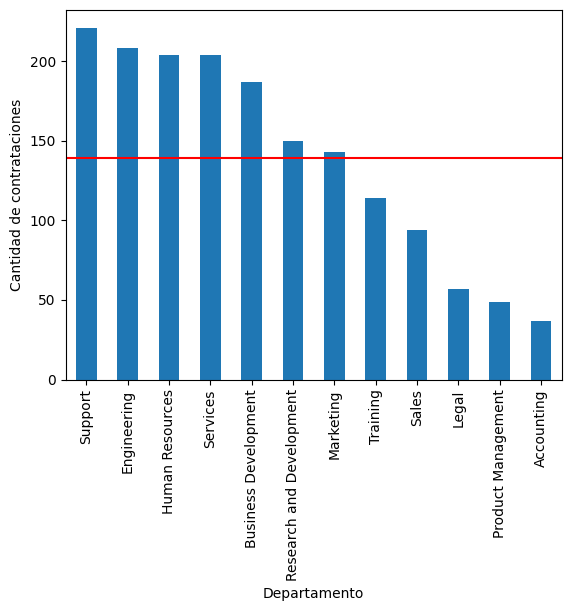

In [12]:
ax = df['department'].value_counts().plot(kind='bar')
ax.set(xlabel='Departamento', ylabel='Cantidad de contrataciones')
ax.axhline(df['department'].value_counts().mean(), color ='red')
ax.plot()

In [14]:
dfdept = pordept.reset_index().rename(columns={'index': "department", 'department': "contr_por_dept"})
dfdept

,department,contr_por_dept
0,Support,221
1,Engineering,208
2,Human Resources,204
3,Services,204
4,Business Development,187
5,Research and Development,150
6,Marketing,143
7,Training,114
8,Sales,94
9,Legal,57


In [15]:
df1 = df[df['department'].isin(depsSupMedia)][['id', 'name', 'department']]
resumen2 = df1.join(dfdept.set_index('department'), on='department').sort_values(by='contr_por_dept', ascending=False)
resumen2


,id,name,department,contr_por_dept
1,2,Ty Hofer,Support,221
691,692,Algernon McCraw,Support,221
1393,1394,Latrena Glasscock,Support,221
729,730,Rodolphe Assiter,Support,221
1704,1705,Bonita Ortiga,Support,221
...,...,...,...,...
242,243,Juliet MacGebenay,Marketing,143
240,241,Benedetto Ropking,Marketing,143
742,743,Georg Prince,Marketing,143
1152,1153,Truman Carde,Marketing,143


In [16]:
resumen2.to_csv('resumen2.csv', index=False)